# 表面張力のbaselineモデル（PLS）を構築

## ライブラリをインポート

In [11]:
import warnings
warnings.filterwarnings("ignore")

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

## グラフ表示の際のフォント種類やフォントサイズを設定

In [12]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"  #'Times New Roman'

## ファイルのコンフィグ情報を定義

In [13]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "exp000"
    target = "表面張力"

## データを読み込み、データフレームに格納

In [14]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter3_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル作製日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,2024/1/19,高岡,NaN,46.9,40,0,2,0,2.0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,2024/1/19,高岡,NaN,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,2024/1/19,高岡,NaN,47.7,40,0,2,0,1.2,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,2024/1/19,高岡,NaN,47.9,40,0,2,0,1.0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,2024/1/19,高岡,NaN,48.4,40,0,2,0,0.5,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_006,2024/1/30,福原,ref,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.7,1.07,9.1,38,NaN,NaN
6,DP_007,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
7,DP_008,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
8,DP_009,2024/1/30,福原,NaN,45.4,40,0,2,0,1.5,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
9,DP_010,2024/1/30,福原,NaN,43.4,40,0,2,0,1.5,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN


## referenceサンプルをデータから削除する

In [15]:
# 備考にrefと書かれているデータを削除
train_df = train_df[train_df["備考"] != "ref"]
# インデックスを振り直す
train_df = train_df.reset_index(drop=True)
train_df

,サンプルID,サンプル作製日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,2024/1/19,高岡,NaN,46.9,40,0,2,0,2.0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,2024/1/19,高岡,NaN,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,2024/1/19,高岡,NaN,47.7,40,0,2,0,1.2,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,2024/1/19,高岡,NaN,47.9,40,0,2,0,1.0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,2024/1/19,高岡,NaN,48.4,40,0,2,0,0.5,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_007,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
6,DP_008,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
7,DP_009,2024/1/30,福原,NaN,45.4,40,0,2,0,1.5,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
8,DP_010,2024/1/30,福原,NaN,43.4,40,0,2,0,1.5,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN
9,DP_011,2024/1/30,福原,NaN,41.4,40,0,2,0,1.5,...,25,NaN,10,5,4.0,1.07,12.7,32,NaN,NaN


## データの列名を確認

In [16]:
# train_dfの列名をリストで取得
columns = train_df.columns
# train_dfの列名を表示
columns

Index(['サンプルID', 'サンプル作製日', '担当者', '備考', '材料１', '材料２', '材料３', '材料４', '材料５',
       '材料６', '材料７', '材料８', '材料９', '材料１０', '材料１１', '材料１２', '材料１３', '塗布量',
       '乾燥方式', '乾燥温度', '乾燥時間', '擦過回数', '擦過圧力', '耐擦過性', '画像濃度', '粘度', '表面張力',
       '保存後粘度', '保存後状態'],
      dtype='object')

## データの欠損を確認

In [17]:
# 欠損のある列を表示
train_df.isnull().sum()

サンプルID      0
サンプル作製日     0
担当者         0
備考         30
材料１         0
材料２         0
材料３         0
材料４         0
材料５         0
材料６         0
材料７         0
材料８         0
材料９         0
材料１０        0
材料１１        0
材料１２        0
材料１３        0
塗布量         0
乾燥方式        0
乾燥温度        0
乾燥時間       13
擦過回数        0
擦過圧力        0
耐擦過性        0
画像濃度        0
粘度          0
表面張力        0
保存後粘度      24
保存後状態      24
dtype: int64

## 使用する説明変数をリストとして定義

In [18]:
numeric_parameter_cols = [
    # 'サンプルID',
    # 'サンプル名',
    # 'サンプル作成日',
    # '担当者',
    # '備考',
    "材料１",
    "材料２",
    "材料３",
    "材料４",
    "材料５",
    "材料６",
    "材料７",
    "材料８",
    "材料９",
    "材料１０",
    "材料１１",
    "材料１２",
    "材料１３",
    "塗布量",
    "乾燥方式",
    "乾燥温度",
    # '乾燥時間',
    "擦過回数",
    "擦過圧力",
    # '耐擦過性','画像濃度', '粘度', '表面張力', '保存後粘度'
]

## 説明変数と目的変数の定義

In [19]:
train_X = train_df[numeric_parameter_cols]
objective_cols = [CFG.target]
train_Y = train_df[objective_cols]

## PLSRegressionを用いたLeave-one-outによる交差検証

0it [00:00, ?it/s]

Index([0], dtype='int64')
RMSE_train: 1.3476625980162749
MAE_train: 1.0103276740765315
R2_train: 0.8281867765944486
Index([1], dtype='int64')
RMSE_train: 1.4286993030245656
MAE_train: 1.0755864706280254
R2_train: 0.8022311280636772
Index([2], dtype='int64')
RMSE_train: 1.42286551922844
MAE_train: 1.0365964844809379
R2_train: 0.7933685162177727
Index([3], dtype='int64')
RMSE_train: 1.4050744991912871
MAE_train: 1.0175767508662235
R2_train: 0.790626596859836
Index([4], dtype='int64')
RMSE_train: 1.230948414549018
MAE_train: 0.9355974347033947
R2_train: 0.80808557328387
Index([5], dtype='int64')
RMSE_train: 1.2835126377794954
MAE_train: 0.9057576386670854
R2_train: 0.8427392343454405
Index([6], dtype='int64')
RMSE_train: 1.2610550789039543
MAE_train: 0.919156725096274
R2_train: 0.8424724869238193
Index([7], dtype='int64')
RMSE_train: 1.4231925006050041
MAE_train: 1.0789155670847008
R2_train: 0.8081727401275257
Index([8], dtype='int64')
RMSE_train: 1.423835708354312
MAE_train: 1.0735930931

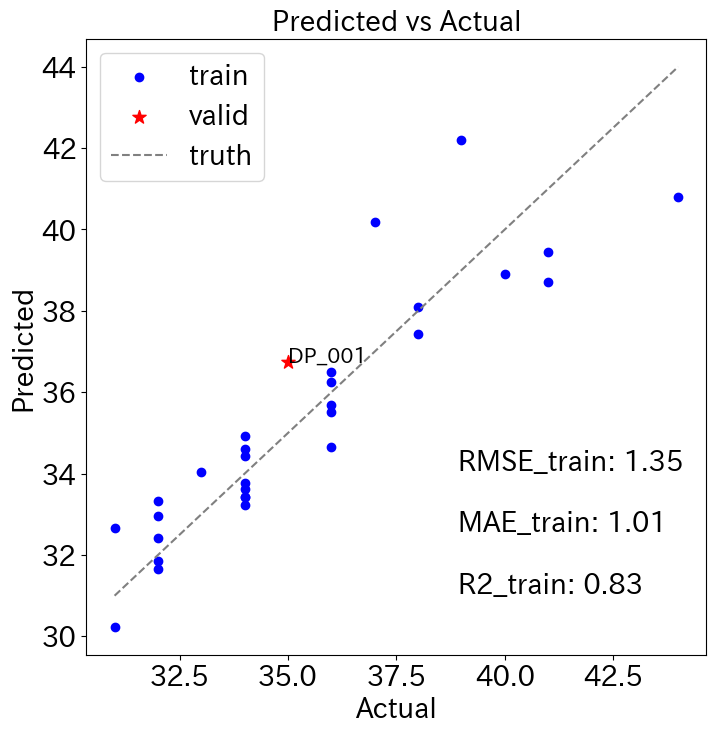

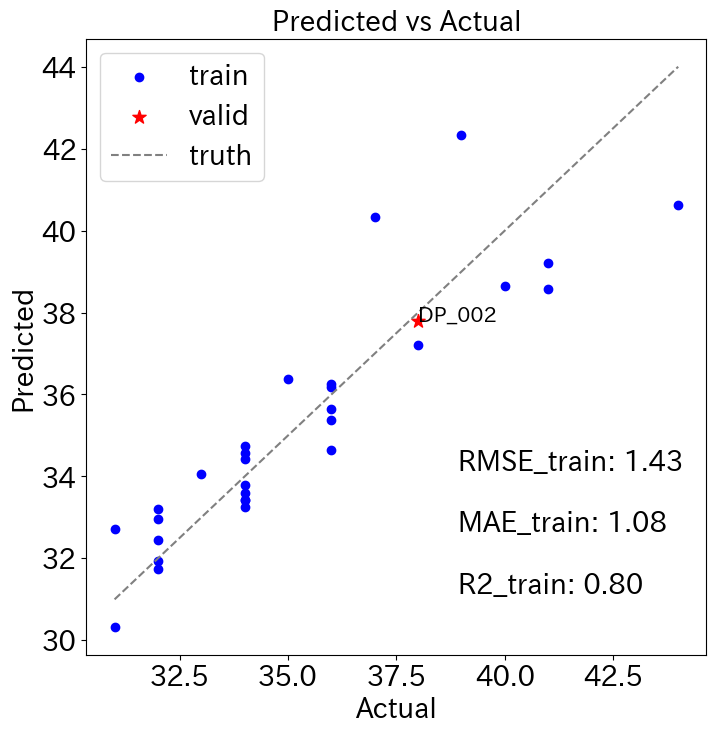

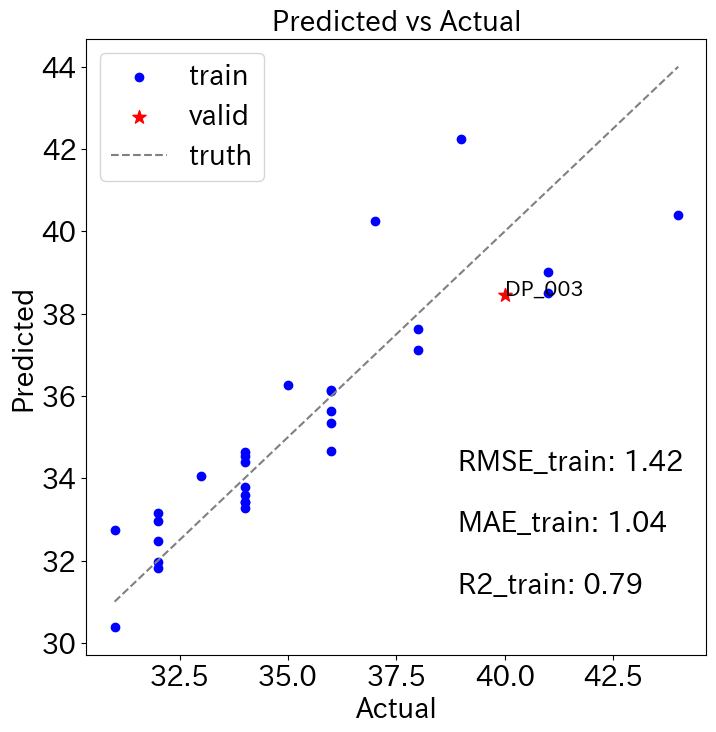

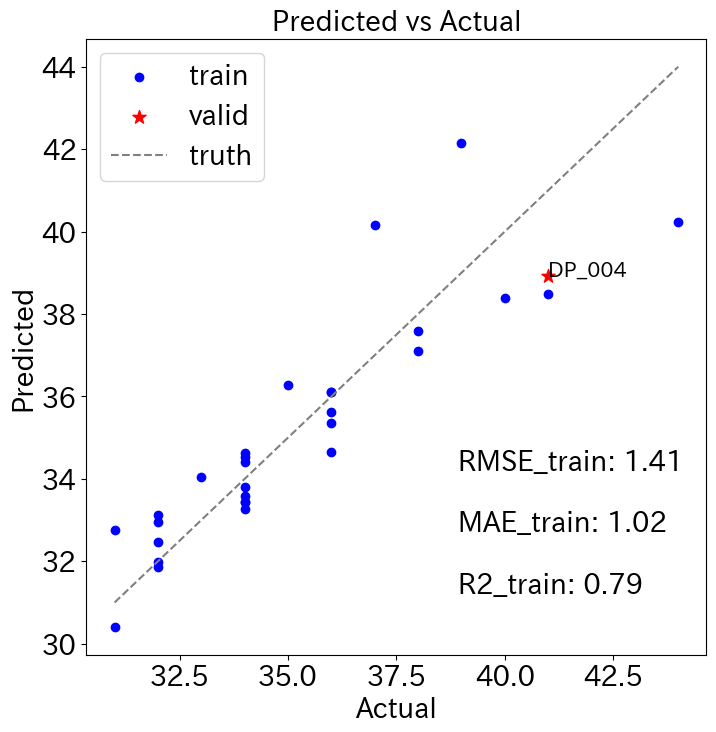

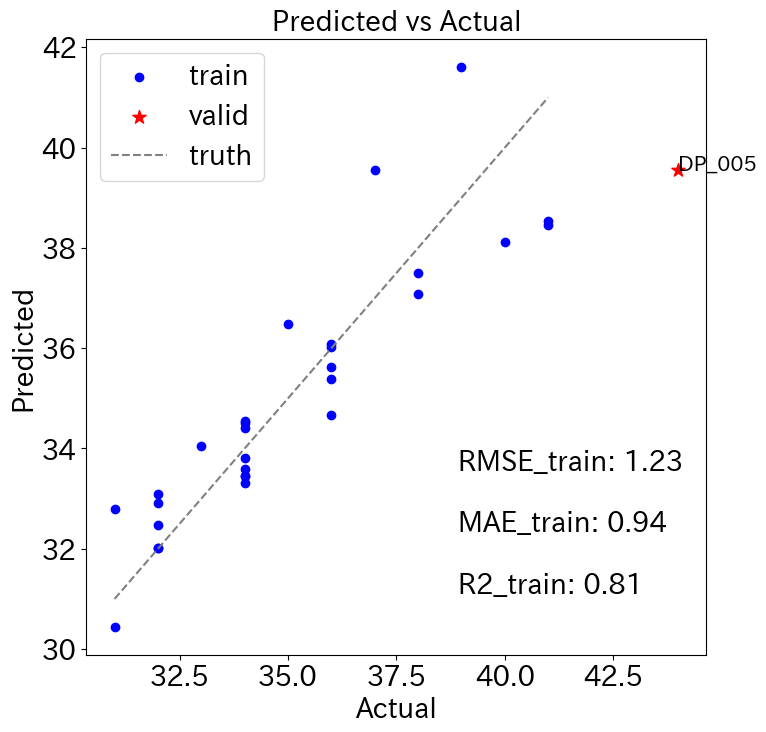

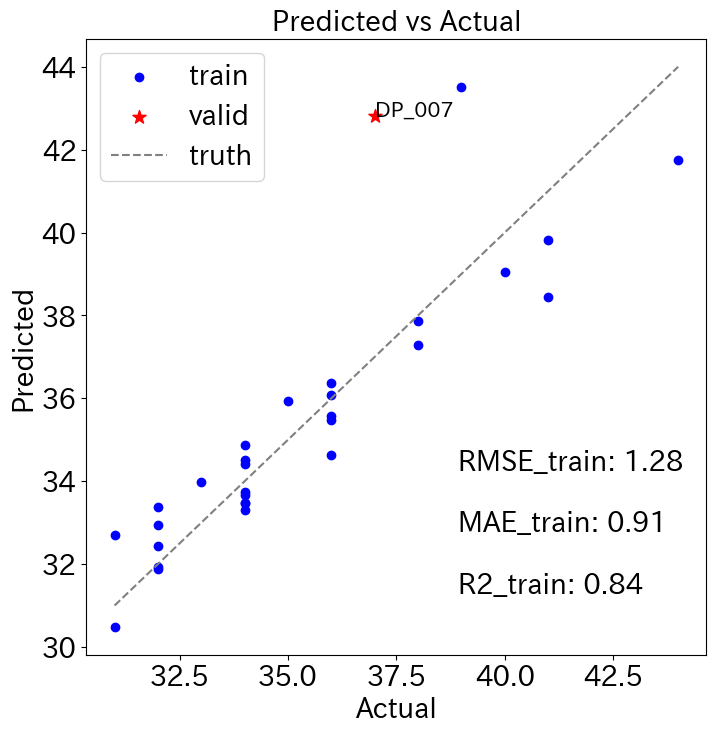

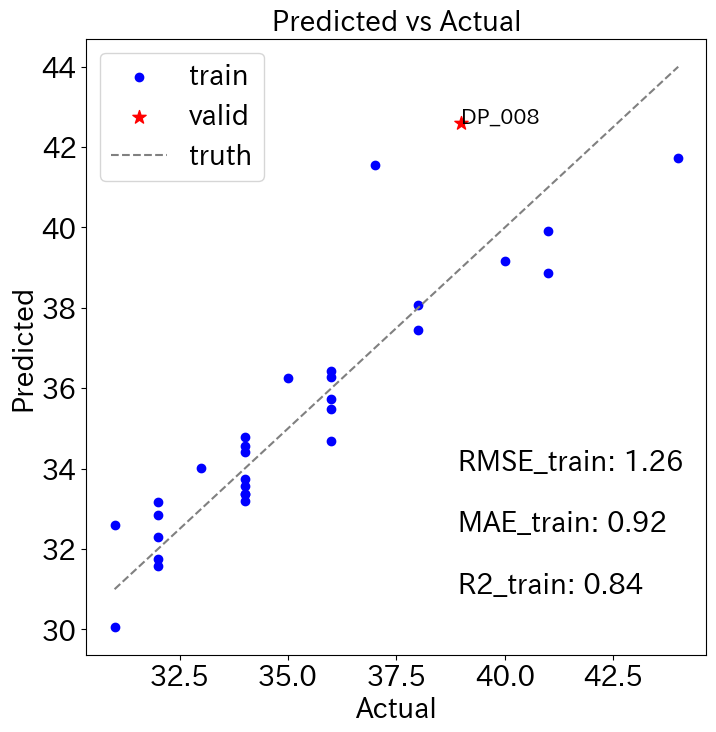

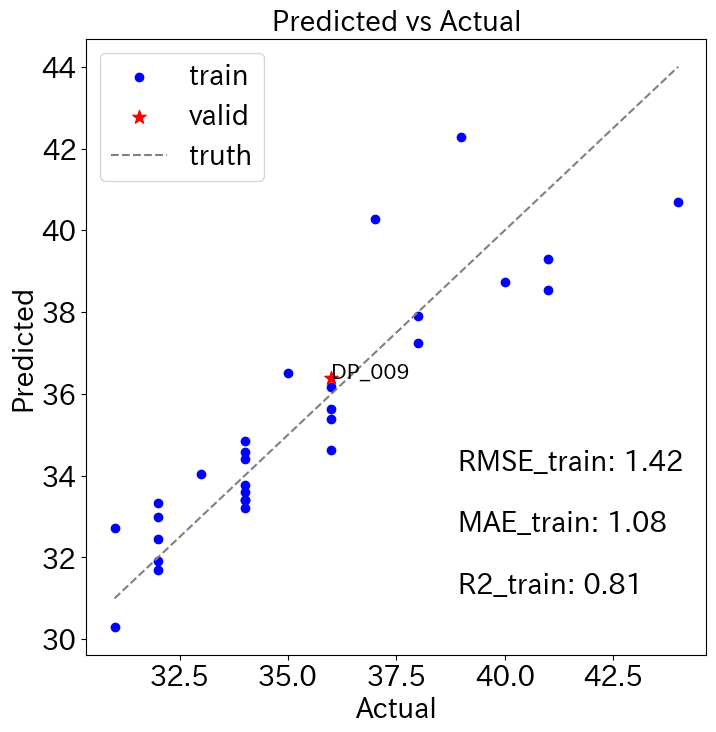

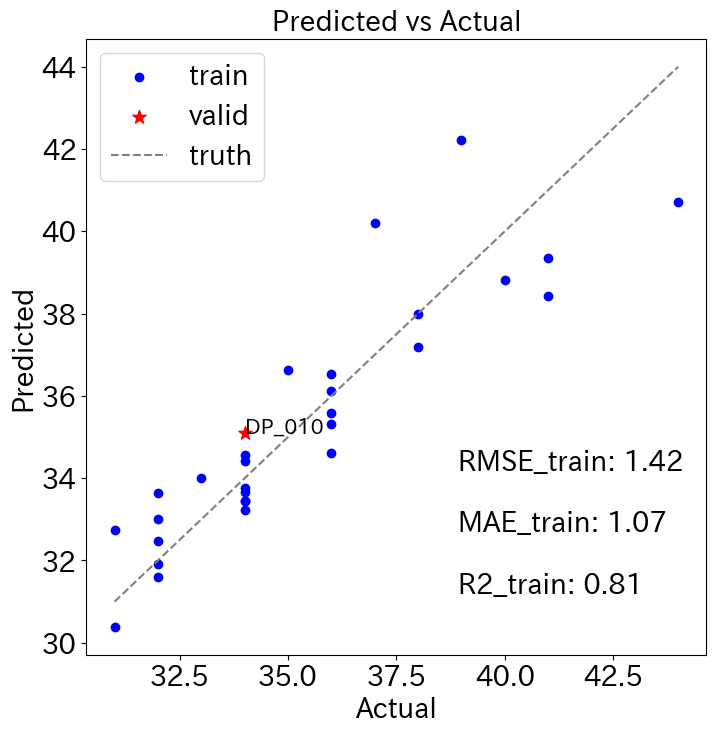

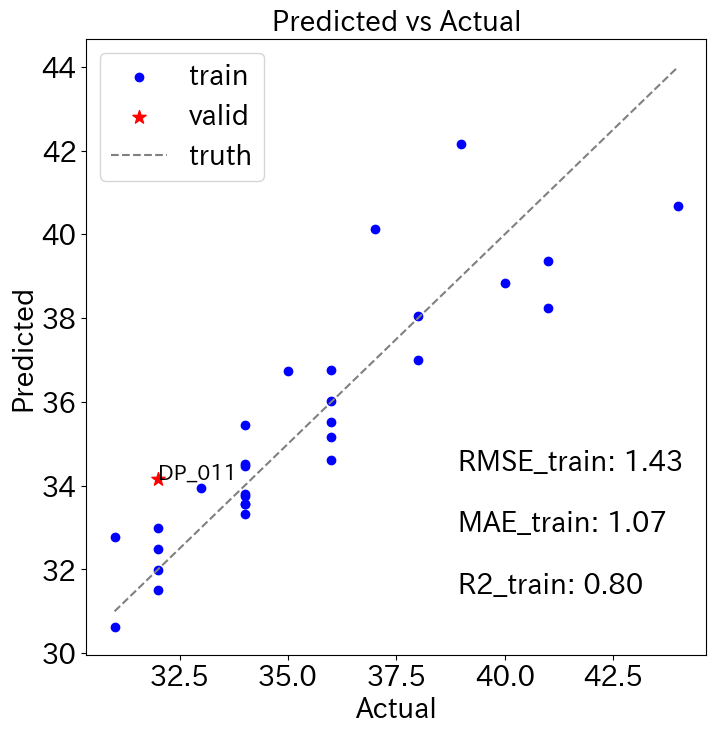

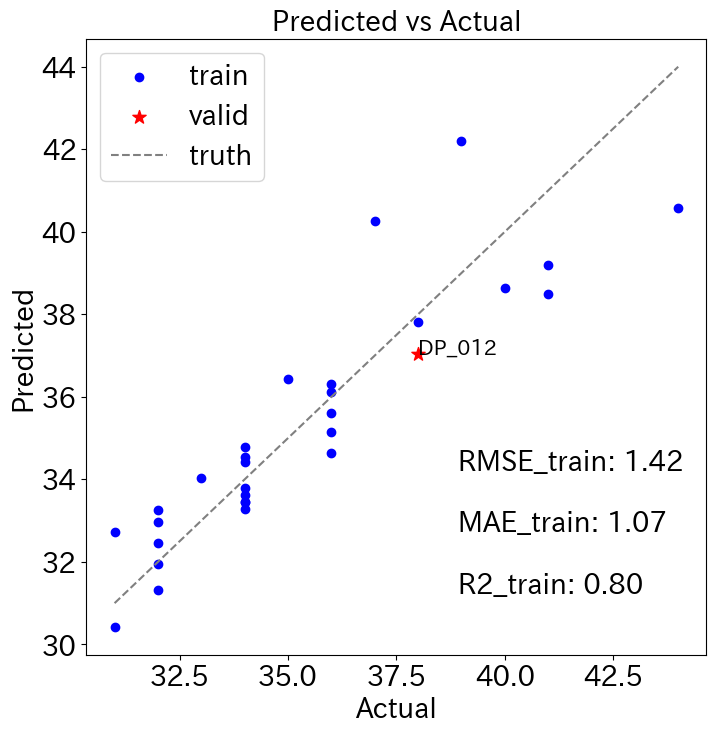

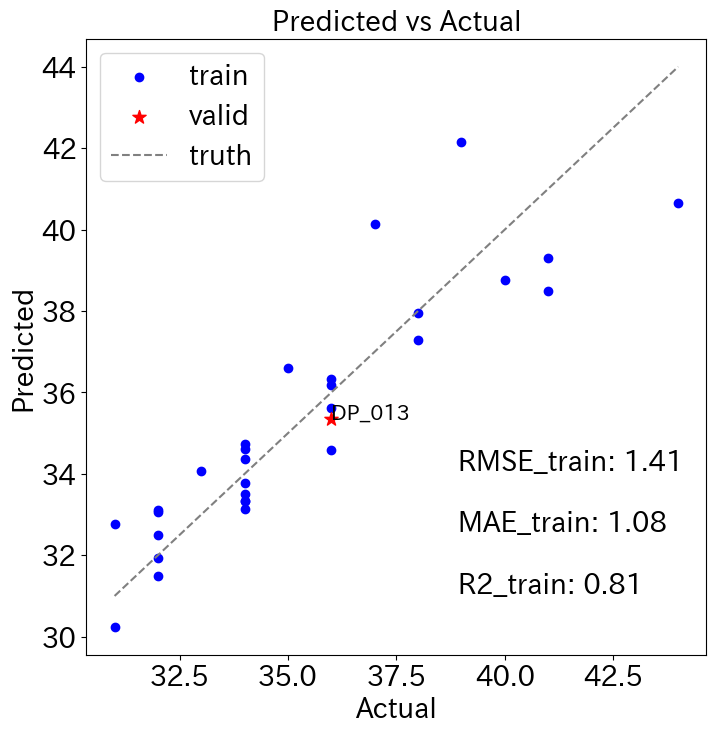

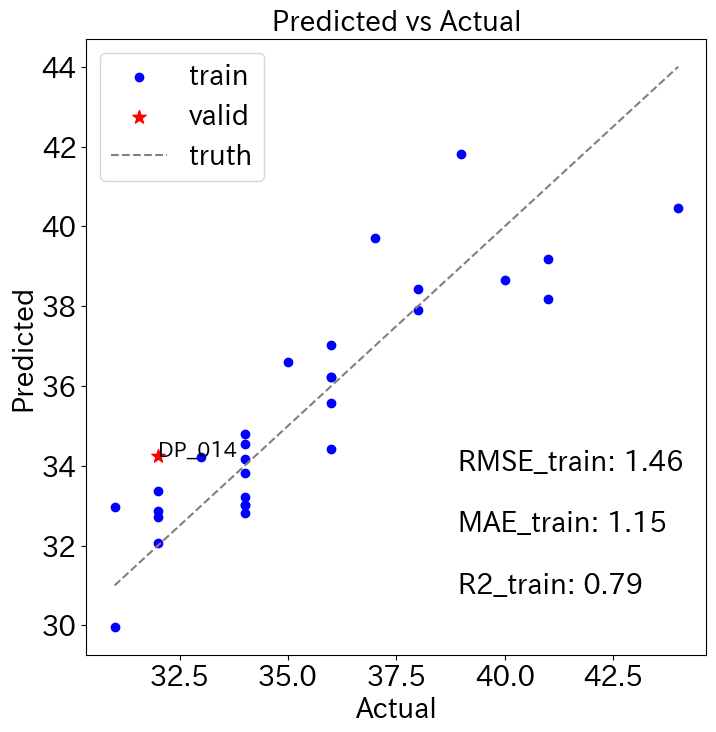

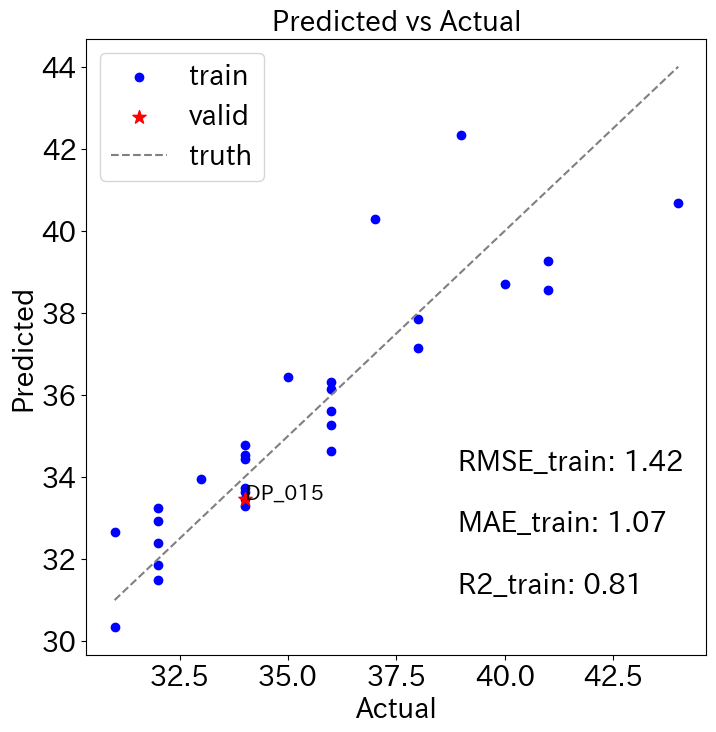

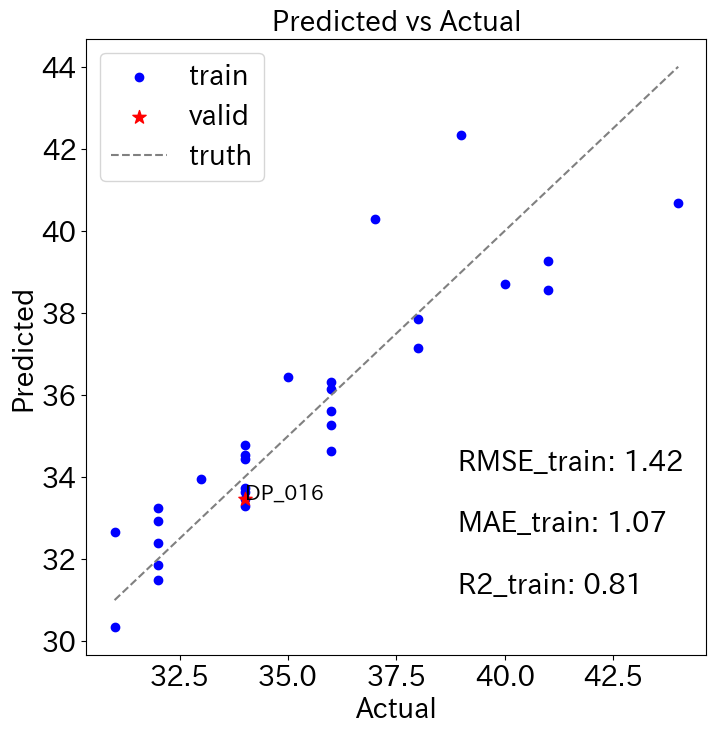

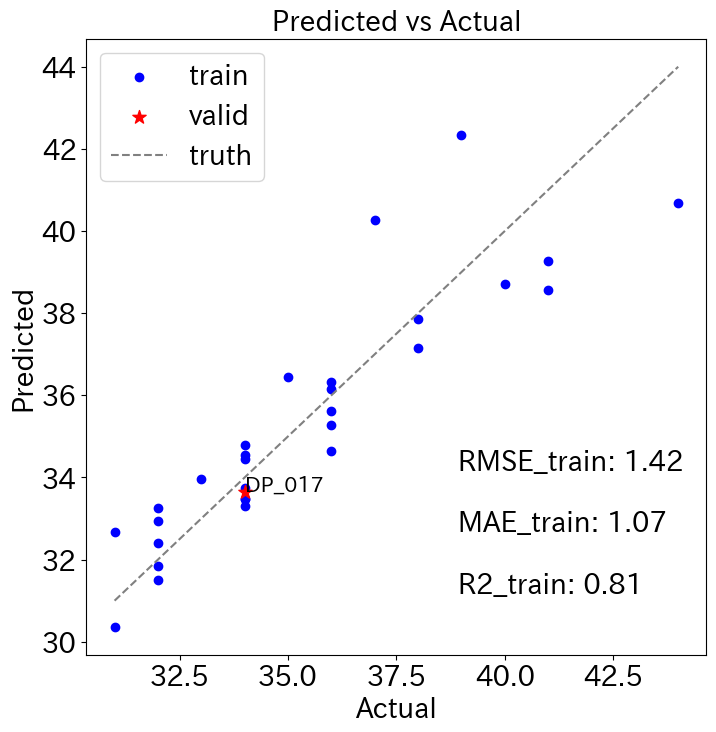

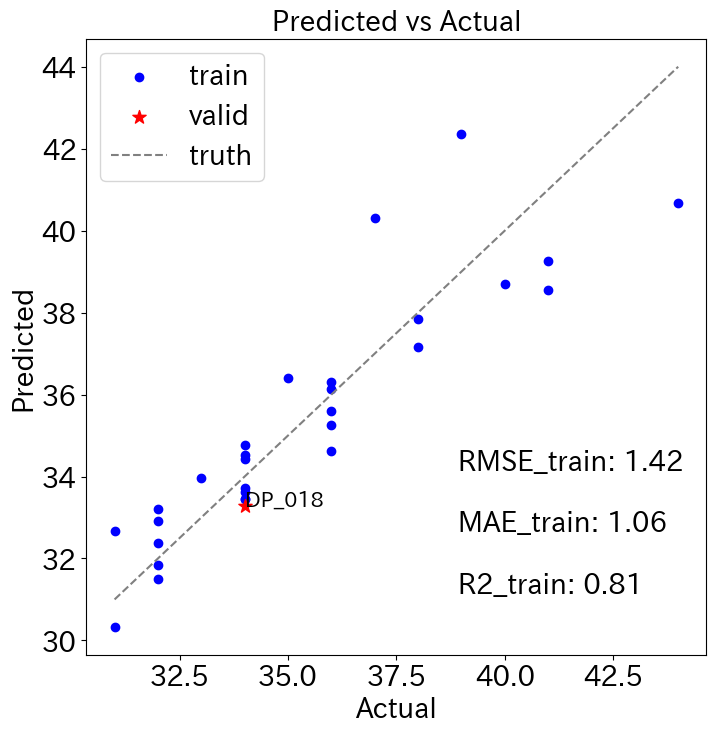

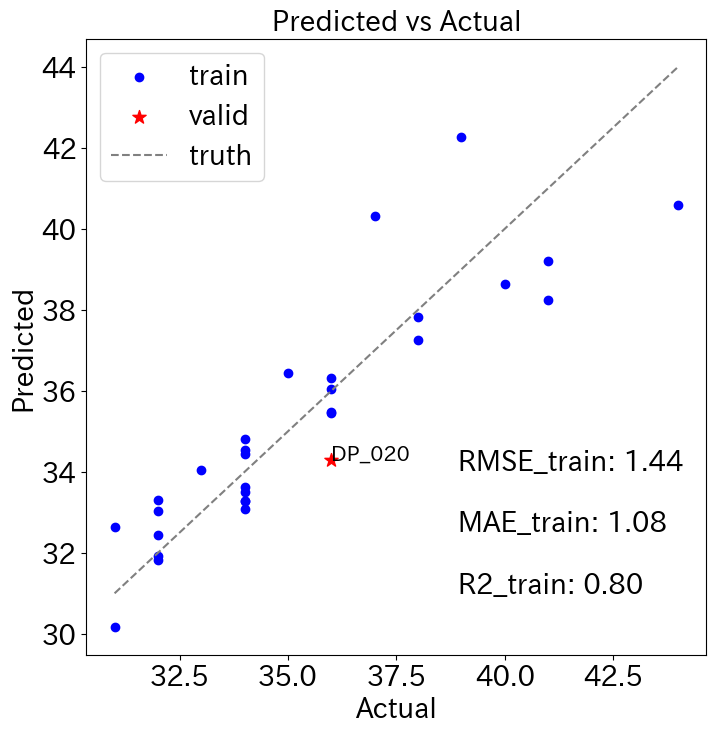

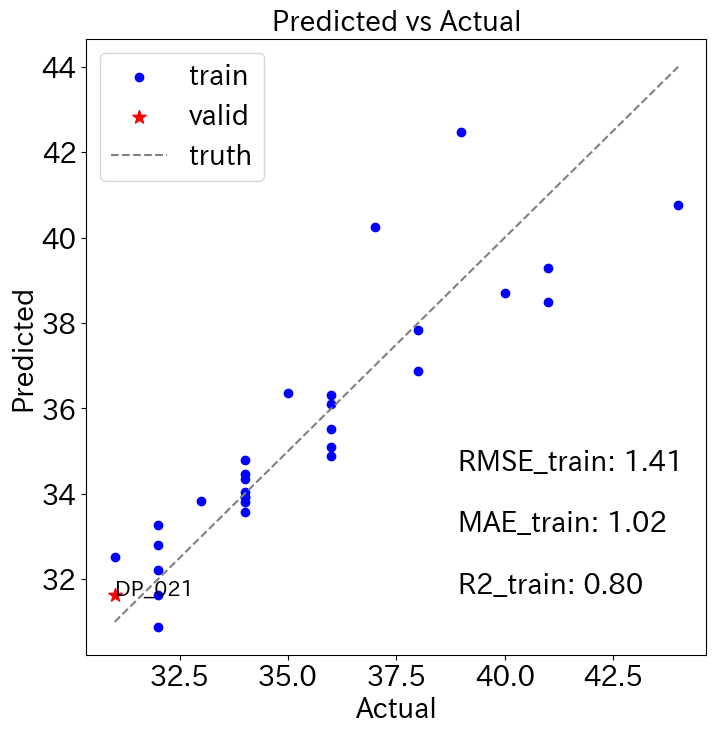

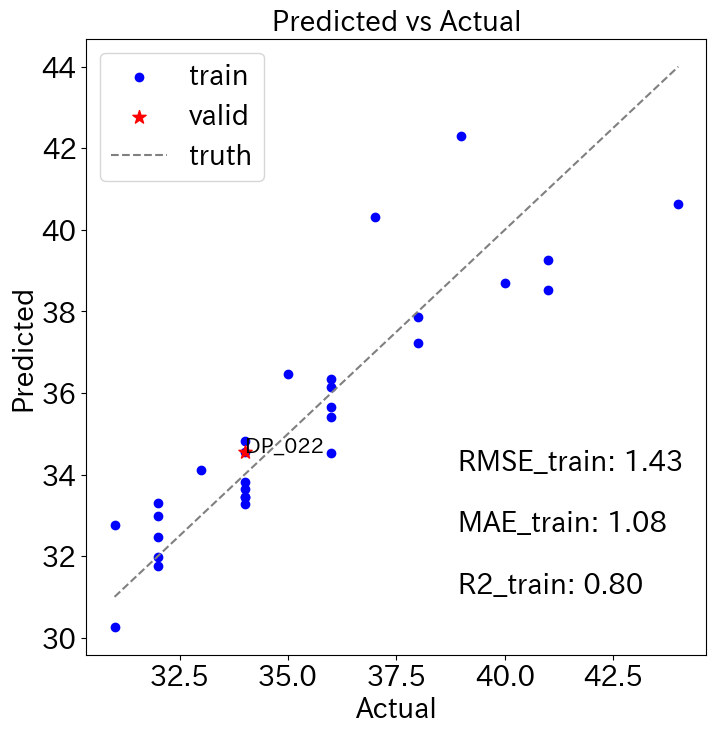

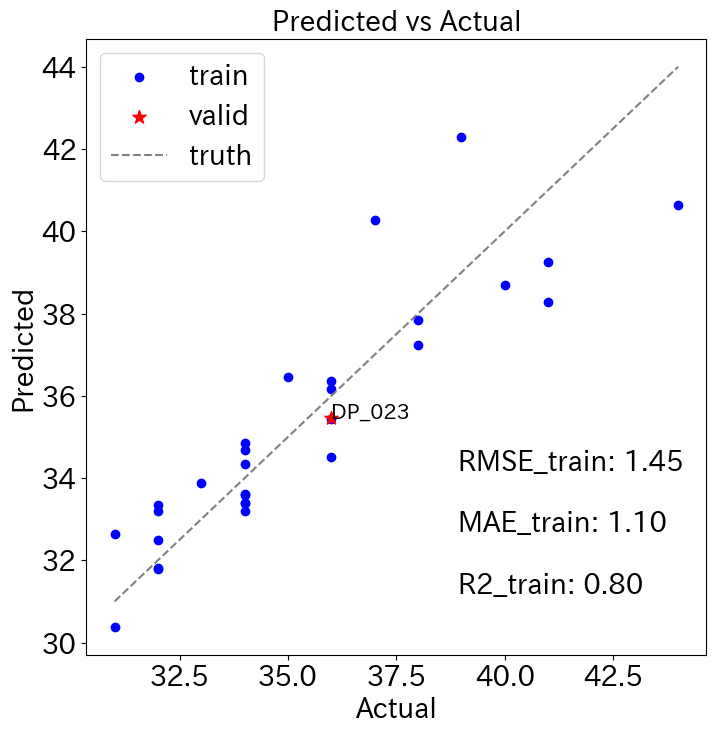

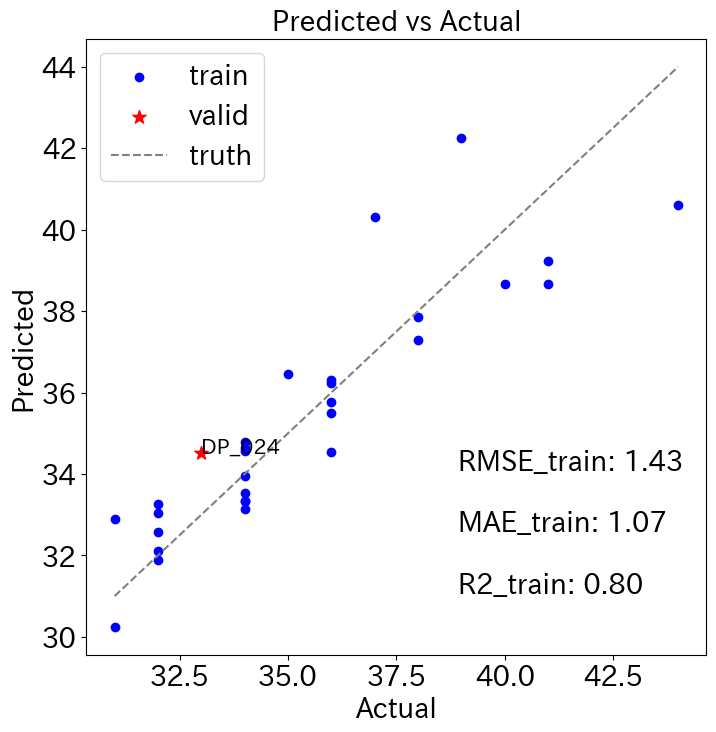

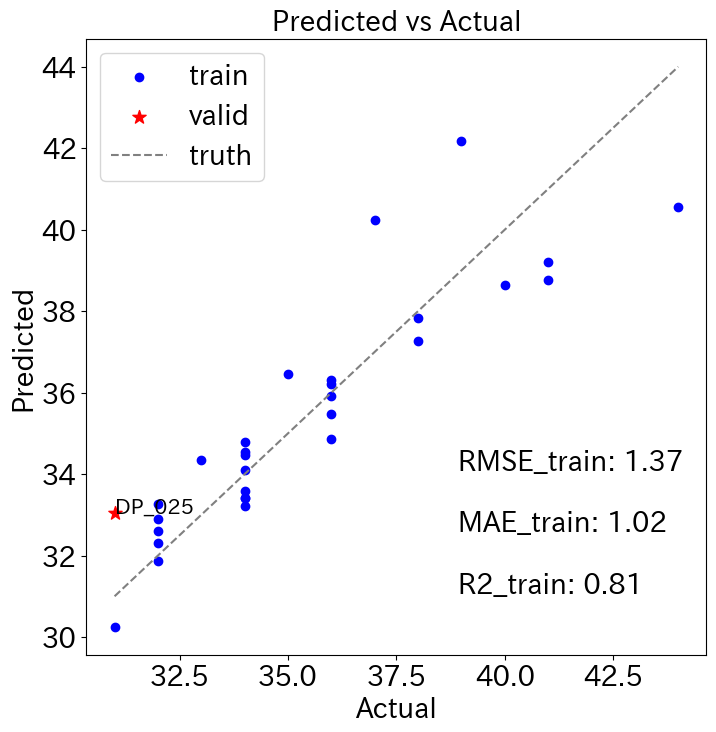

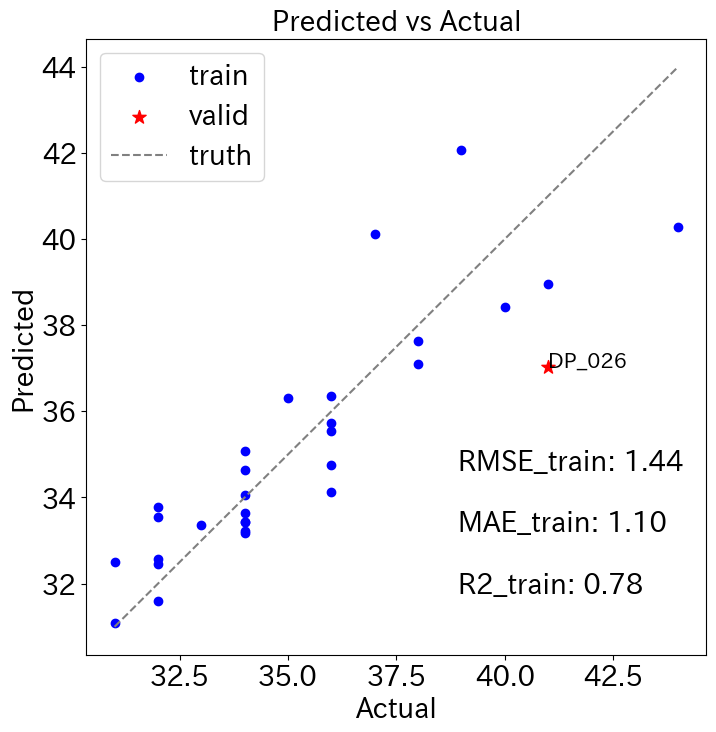

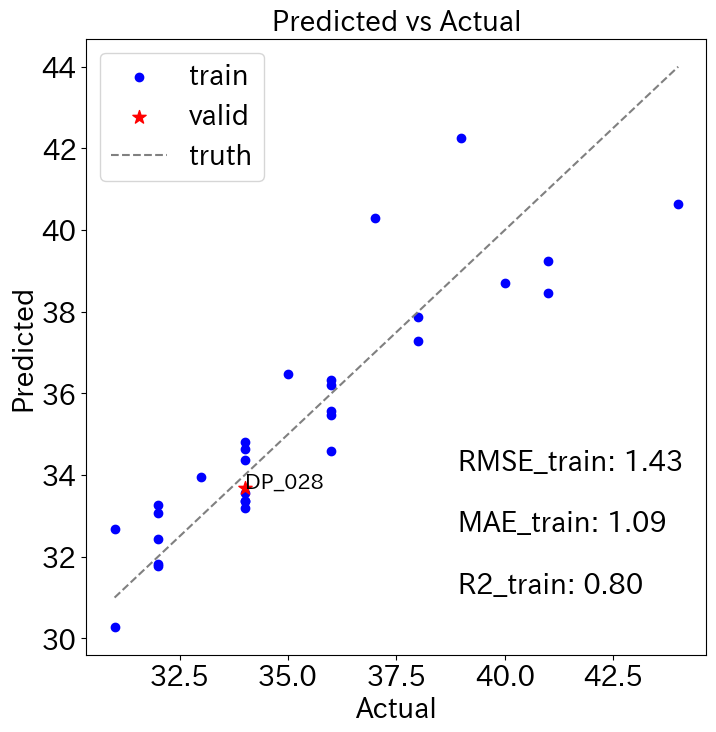

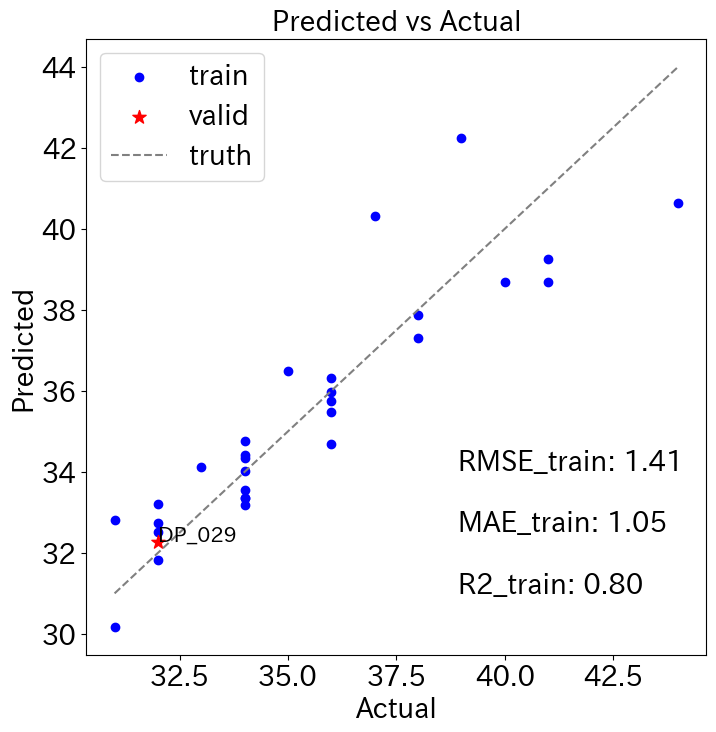

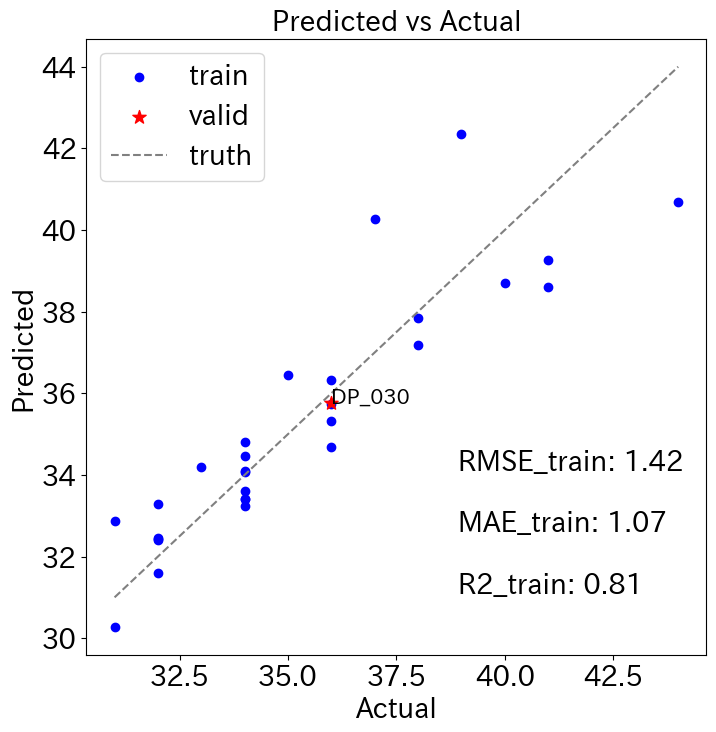

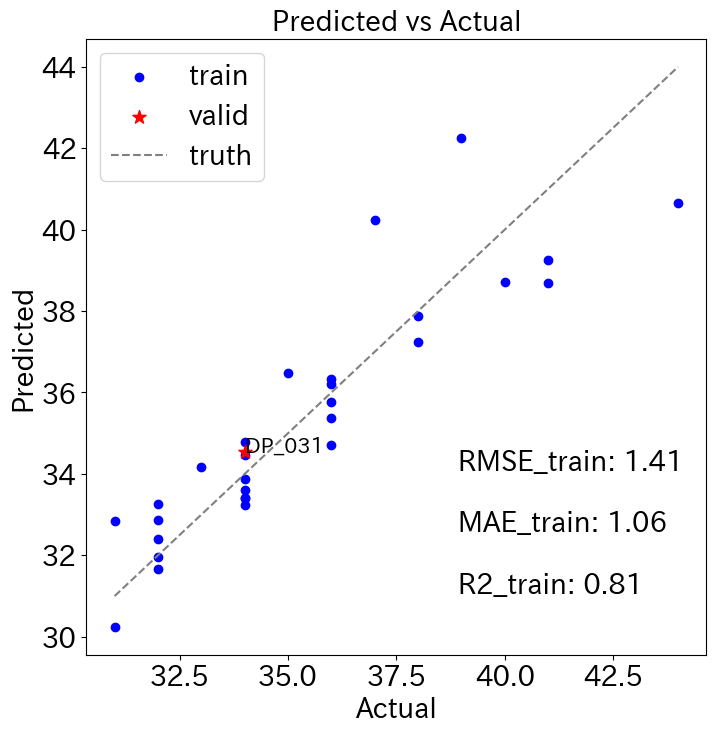

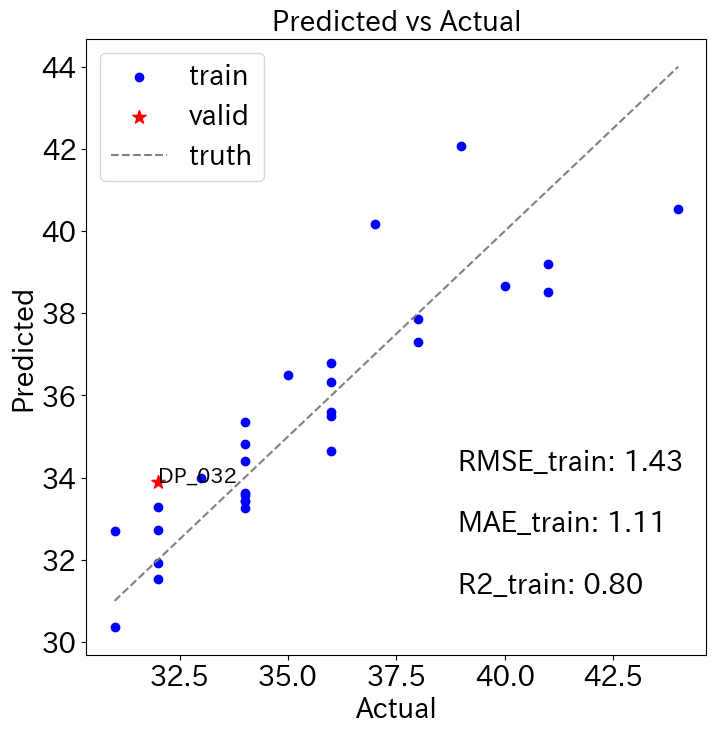

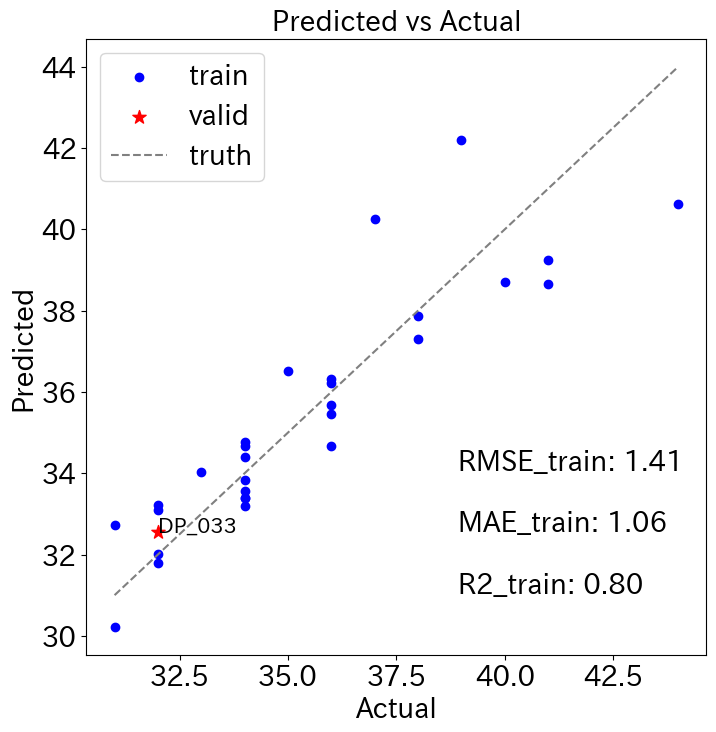

In [20]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue")
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(train_df.iloc[valid_index]["サンプルID"]):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

## Out-Of-Fold(OOF)のプロット

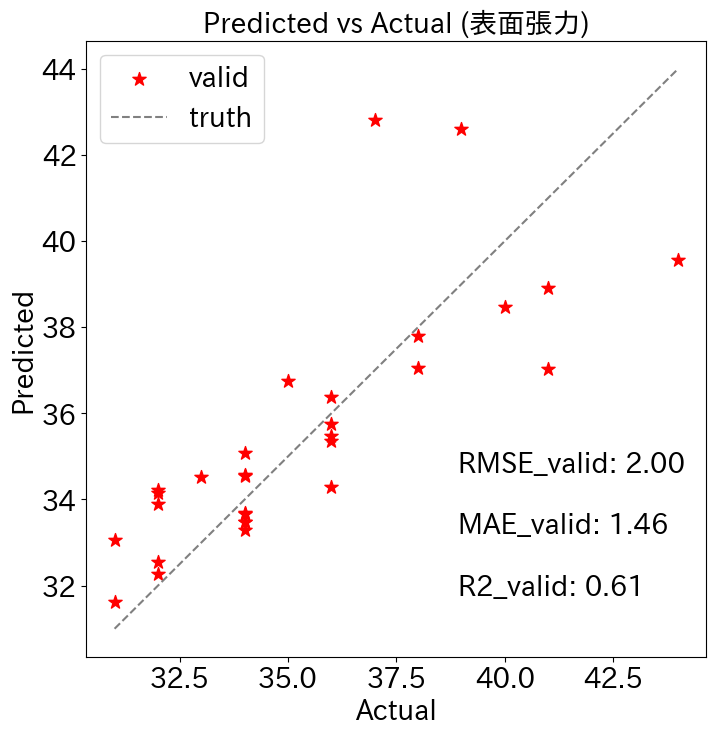

In [21]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual ({CFG.target})")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

## Out-Of-Fold(OOF)のプロット&各水準のIDを表示

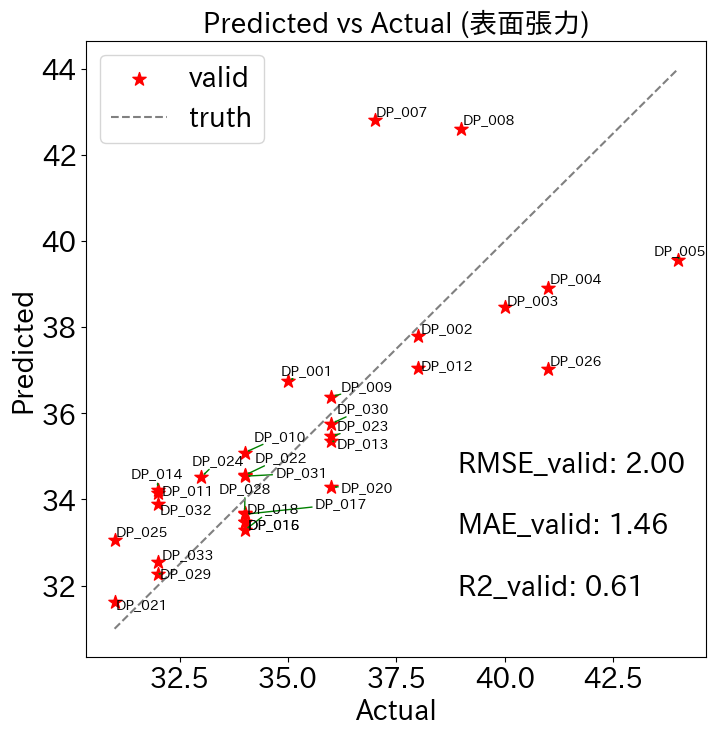

In [22]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual ({CFG.target})")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], train_df["サンプルID"][i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

## Leave-one-outにより得られた標準回帰係数の個数をカウント

In [23]:
len(coef)

30

## Leave-one-outによる各モデルの標準回帰係数の平均を算出

In [24]:
# 全てのモデルの係数の平均を算出
coef = np.array(coef)
coef = np.mean(coef, axis=0)
coef

array([[ 0.60066116],
       [-0.10565639],
       [ 0.07831978],
       [-0.15964841],
       [ 0.0242014 ],
       [-0.29890794],
       [-0.04820626],
       [ 0.06445457],
       [-0.0884048 ],
       [-0.03164183],
       [-0.14815554],
       [-0.22133397],
       [ 0.        ],
       [ 0.        ],
       [-0.11130847],
       [-0.10880408],
       [ 0.        ],
       [ 0.        ]])

## 標準回帰係数の平均をデータフレームに格納

In [25]:
# coefをDataFrameに変換
coef_df = pd.DataFrame(coef, index=numeric_parameter_cols, columns=["coef"])
coef_df

,coef
材料１,0.600661
材料２,-0.105656
材料３,0.078320
材料４,-0.159648
材料５,0.024201
材料６,-0.298908
材料７,-0.048206
材料８,0.064455
材料９,-0.088405
材料１０,-0.031642


## 標準回帰係数の平均のデータフレームを絶対値の降順に並び替え

In [26]:
# coef_dfをcoefの絶対値の降順にソート
coef_df = coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)
coef_df

,coef
材料１,0.600661
材料６,-0.298908
材料１２,-0.221334
材料４,-0.159648
材料１１,-0.148156
乾燥方式,-0.111308
乾燥温度,-0.108804
材料２,-0.105656
材料９,-0.088405
材料３,0.078320


## 標準回帰係数の平均をプロットして特徴量重要度として可視化

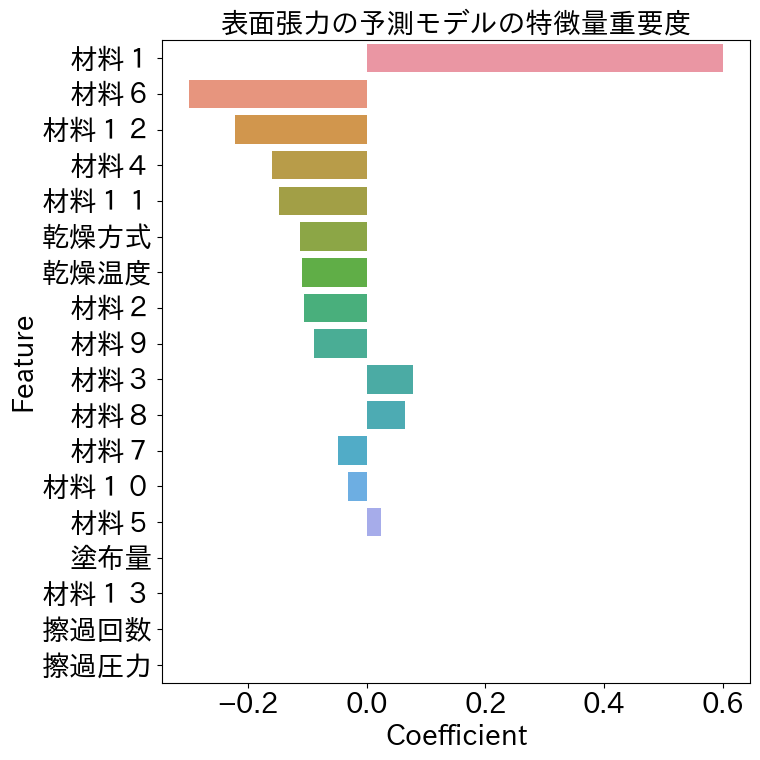

In [27]:
# coef_dfをsns.barplotで可視化
plt.figure(figsize=(8, 8))
sns.barplot(data=coef_df, x="coef", y=coef_df.index)
plt.title(f"{CFG.target}の予測モデルの特徴量重要度")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()

## テストデータを読み込み、データフレームに格納

In [28]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter3_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル作製日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_test_01,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.64,10.3,32,76.7,ゲル化
1,DP_test_02,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.61,10.2,32,12.6,正常
2,DP_test_03,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.57,10.0,32,33.7,ゲル化
3,DP_test_04,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.46,9.2,34,11.6,正常
4,DP_test_05,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.43,9.1,34,11.5,正常
5,DP_test_06,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.41,9.0,34,11.4,正常
6,DP_test_07,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.25,8.1,35,10.5,正常
7,DP_test_08,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.24,8.1,35,10.5,正常
8,DP_test_09,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.22,8.0,35,10.4,正常


## テストデータについてLeave-one-outで得られた全てのモデルで予測して、その平均値をテストデータにおける予測値とする

In [29]:
# 全てのmodelで予測してその平均をとる
test_X = test_df[numeric_parameter_cols]
preds = []
for model in models:
    pred = scaler_y.inverse_transform(
        model.predict(scaler_x.transform(test_X)).reshape(-1, 1)
    )
    preds.append(pred)
preds = np.array(preds)
preds = preds.mean(axis=0)
preds

array([[32.87337313],
       [32.54619052],
       [32.21900792],
       [34.12734315],
       [33.90922141],
       [33.69109968],
       [35.38131317],
       [35.2722523 ],
       [35.16319144]])